## Merge Root Files

In [14]:
import uproot
import os
import numpy as np

def merge_files(directory, starts_with, output_name):

    file_list = []

    for file in os.listdir(directory):
        if file.endswith('.root') and not file.startswith('merge') and not file.startswith(output_name):
            if not starts_with == '' and file.startswith(starts_with):
                    file_list.append(os.path.join(directory, file))
            else:
                file_list.append(os.path.join(directory, file))
    
    merged_file = os.path.join(directory, output_name)
    
    counter = 0
    while True:
        if not os.path.exists(f"{merged_file}{counter}.root"):
            merged_file = f"{merged_file}{counter}.root"
            break
        counter = counter + 1

    with uproot.recreate(merged_file) as f_out:
        data_dict = {}  # Dictionary to store merged data temporarily
        
        for file in file_list:
            
            with uproot.open(file) as f_in:
                for key in f_in.keys():
                    obj = f_in[key]
                    
                    if isinstance(obj, uproot.TTree):
                        new_data = obj.arrays(library="np")
                        
                        # Extract base key name (ignore cycle numbers)
                        base_key = key.split(';')[0]

                        # If base_key is already in data_dict, concatenate data
                        if base_key in data_dict:
                            existing_data = data_dict[base_key]
                            combined_data = {k: np.concatenate([existing_data[k], new_data[k]]) for k in new_data.keys() if k in existing_data}
                            # Update with the combined data
                            data_dict[base_key] = {**existing_data, **combined_data}
                        else:
                            # If base_key is not in data_dict, add new data
                            data_dict[base_key] = new_data

        for key, data in data_dict.items():
            f_out[key] = data


    print("Merged files into", merged_file)

In [ ]:
directory = 'BUILD/ROOT'
starts_with = 'root'
output_name = 'merge'

merge_files(directory, starts_with, output_name)

## Root to Dataframe

In [1]:
import uproot
import os
import numpy as np
import dask.array as da
import dask.dataframe as dd

def root_to_dask(directory, root_name_starts, tree_name, x_branch, y_branch):
    
    file_name = os.path.join(directory, root_name_starts + ".root")

    with uproot.open(file_name) as root_file:
        tree = root_file[tree_name]
        if tree is None:
            print(f"Tree '{tree_name}' not found in {file_name}")
            return

        x_values = tree[x_branch].array(library="np") if x_branch in tree else None
        y_values = tree[y_branch].array(library="np") if y_branch in tree else None

        decimal_places = 2

        if x_values is not None:
            x_values = np.round(x_values, decimal_places)
        if y_values is not None:
            y_values = np.round(y_values, decimal_places)

        if x_values is None or y_values is None:
            print(f"Could not retrieve data for branches {x_branch} or {y_branch}")
            return

        x_dask_array = da.from_array(x_values, chunks="auto")
        y_dask_array = da.from_array(y_values, chunks="auto")

        dask_df = dd.from_dask_array(da.stack([x_dask_array, y_dask_array], axis=1), columns=[x_branch, y_branch])
        
        return dask_df

In [2]:
directory = 'RESULTS/'
root_name_starts = "arm_80kev_20M"

tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"

# tree_name = "G4_PCM"
# x_branch  = "PositionX"
# y_branch  = "PositionY"

dataframe = root_to_dask(directory, root_name_starts, tree_name, x_branch, y_branch)

x_branch = "X_axis"
y_branch = 'Y_axis'

# x_branch = 'PositionX'
# y_branch = 'PositionY'

x_data = dataframe[x_branch].to_dask_array(lengths=True)
y_data = dataframe[y_branch].to_dask_array(lengths=True)

## Dask Dataframe to Heatmap

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import dask.array as da
import dask.dataframe as dd

def heatmap_array_dask(x_data, y_data, size, num, save_as):

    set_bins = np.arange(-size, size + 1, size/num)
    heatmap, x_edges, y_edges = da.histogram2d(x_data, y_data, bins = [set_bins, set_bins])
    heatmap = heatmap.T

    heatmap = heatmap.compute()  
    x_edges = x_edges.compute()  
    y_edges = y_edges.compute()

    normal_map = 1 - heatmap / np.max(heatmap)

    columns = heatmap.shape[1]
    column_i = int(columns * 0.1)
    column_j = int(columns * 0.9)

    rows = heatmap.shape[0]
    row_i = int(rows * 0.01)
    row_j = int(rows * 0.1)

    maxi = np.max(normal_map[row_i:row_j, column_i:column_j])
    maxi = maxi * 1.1
    # print('altura de ruido:', round(maxi, 4))

    normal_map[normal_map < maxi] = 0

    plt.figure(figsize = (10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(normal_map, cmap = 'gray', extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    plt.axis('off')
    if save_as != '': plt.savefig('Results/' + save_as + '.png', bbox_inches = 'tight', dpi = 900)
    
    plt.subplot(1, 2, 2)
    plt.plot(normal_map[:][rows//2])

    return normal_map, x_edges, y_edges

In [ ]:
size = 60
bins = 50

save_as = 'prueba2'

htmp_array, xlim, ylim = heatmap_array_dask(x_data, y_data, size, bins, save_as)

## Eliminate Noise by Fourier Transform

In [42]:
import numpy as np
from scipy.fft import fft2, fftshift, ifft2
import matplotlib.pyplot as plt
from scipy import signal

def Denoise(htmp_array, hann, alpha):

    image = htmp_array

    fft_image = fft2(image)
    fft_image = fftshift(fft_image)

    rows, cols = image.shape

    hann = False
    if hann == True:
    
        l = rows * alpha
        a = np.hanning(l)
        b = np.hanning(l)

        padding_size = rows - len(a)
        left_padding = padding_size // 2
        right_padding = padding_size - left_padding
        a = np.pad(a, (left_padding, right_padding), mode='constant')

        padding_size = cols - len(b)
        left_padding = padding_size // 2
        right_padding = padding_size - left_padding
        b = np.pad(b, (left_padding, right_padding), mode='constant')

        window = np.outer(a, b)

    else:

        a = signal.windows.tukey(rows, alpha)
        b = signal.windows.tukey(rows, alpha)
        window = np.outer(a, b)

    plt.figure(figsize=(10, 2))
    plt.subplot(1, 3, 2)
    plt.plot(a)

    fft_image_2 = fft_image * (window)

    plt.subplot(1, 3, 3)
    plt.plot(np.abs((fft_image_2[:][rows//2])))

    fft_image = fftshift(fft_image_2)
    fft_image = (ifft2(fft_image))
    fft_image = (np.abs(fft_image))

    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Filtered Image')
    plt.imshow(fft_image, cmap='gray')
    # plt.savefig('Results/four1.jpg', dpi = 300)
    plt.show()

    print(fft_image.shape)
    plt.plot(fft_image[:][60])

    return fft_image

In [ ]:
hann = False
alpha = .4
array = htmp_array
fft_image = Denoise(array, hann, alpha)

## Denoise with Skimage.Denoise_Bilateral

In [ ]:
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt

original_image = htmp_array
denoised_image = denoise_bilateral(original_image, sigma_color = 0.03, sigma_spatial = 1, channel_axis = None)

save_as = 'hola'

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(denoised_image, cmap = 'gray')
plt.title('Denoised Image')
plt.axis('off')
if save_as != '': plt.savefig('RESULTS/' + save_as + '.png', bbox_inches = 'tight', dpi = 900)

plt.subplot(1, 2, 2)
plt.imshow(original_image, cmap = 'gray')
plt.title('Original Image')
plt.axis('off')

plt.show()

## Calculate Fixed CNR 

In [13]:
from PIL import Image
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

def CNR(image_path):
    image = Image.open(image_path)
    cropped_image = image.crop((520, 450, image.width - 580, image.width - 440))
    data = np.array(cropped_image)

    plt.imshow(data)

    signal_avg = 0
    background_avg = 0
    background_std = 0

    x1_signal = 1160
    y1_signal = 1130
    x2_signal = 1740
    y2_signal = 1980

    plt.gca().add_patch(plt.Rectangle((x1_signal, y1_signal), x2_signal - x1_signal, y2_signal - y1_signal, 
                                    linewidth=2, edgecolor='yellow', facecolor='none'))


    if x2_signal > x1_signal:
        if y2_signal > y1_signal:
            signal = data[round(y1_signal):round(y2_signal), round(x1_signal):round(x2_signal)]
        else:
            signal = data[round(y2_signal):round(y1_signal), round(x1_signal):round(x2_signal)]
    else:
        if y2_signal > y1_signal:
            signal = data[round(y1_signal):round(y2_signal), round(x2_signal):round(x1_signal)]
        else:
            signal = data[round(y2_signal):round(y1_signal), round(x2_signal):round(x1_signal)]

    signal_avg = np.average(signal)
    print("Signal avg: "+str(signal_avg))

    x1_background = 1790
    y1_background = 1130
    x2_background = 1940
    y2_background = 1980

    plt.gca().add_patch(plt.Rectangle((x1_background, y1_background), x2_background - x1_background, y2_background - y1_background, 
                                    linewidth=2, edgecolor='red', facecolor='none'))


    if x2_background > x1_background:
        if y2_background > y1_background:
            background = data[round(y1_background):round(y2_background), round(x1_background):round(x2_background)]
        else:
            background = data[round(y2_background):round(y1_background), round(x1_background):round(x2_background)]
    else:
        if y2_background > y1_background:
            background = data[round(y1_background):round(y2_background), round(x2_background):round(x1_background)]
        else:
            background = data[round(y2_background):round(y1_background), round(x2_background):round(x1_background)]

    background_avg = np.average(background)
    background_std = np.std(background)

    print("Background avg: "+str(background_avg))
    print("Background std dev: "+str(background_std))

    cnr = (signal_avg-background_avg)/background_std
    print("CNR: ", round(cnr, 1))

In [ ]:
image_path = "RESULTS/" + "" + "prueba2" + ".png"

CNR(image_path)

## Save Plotly Heatmap

In [114]:
import plotly.graph_objects as go
import plotly.io as pio

def heatmap2(array, xlim, ylim, title, x_label, y_label, width, height, save_as):

    fig = go.Figure(go.Heatmap(z = array, x = xlim, y = ylim,
                                colorscale = [[0, 'black'], [1, 'white']], 
                                colorbar = dict(title = "Density", tickfont = dict(family = 'Merriweather', size = 16, color = 'Black'))))
    
    font_family = 'Merriweather'
    font_small  = 16
    font_medium = 20
    font_large  = 18
    
    fig.update_layout(
                    title = dict(text = title, font = dict(family = font_family, size = font_large, color = "Black"), 
                                 x = 0.51, y = 0.93, yanchor = 'middle', xanchor = 'center'),
                    xaxis_title = dict(text = x_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    yaxis_title = dict(text = y_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    xaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 25),
                    yaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 10),
                    width  = width,
                    height = height,
                    margin = dict(l = 105, r = 90, t = 90, b = 90)
    )
   
    if save_as != '': pio.write_image(fig, 'Results/' + save_as + '.png', width = width, height = height, scale = 5)
    fig.show()

In [ ]:
array = htmp_array
# array = denoised_image
# array = fft_image
array = bone

title   = r"$ \large{ \text{Healthy Bone, 80keV, 250M Beams,} } \ \normalsize{ \theta = 0° } $"
x_label = r"$ \large{ \text{X Axis} \ (mm)} $"
y_label = r"$ \large{ \text{Y Axis} \ (mm)} $"

width  = 800
height = 800

save_as = ''

heatmap2(array, xlim, ylim, title, x_label, y_label, width, height, save_as)

## Isolate Bone or Tissue

In [15]:
import Isolate_Bone as commet
import matplotlib.pyplot as plt

def Isolate(directory, rootnames, tree_name, x_branch, y_branch, size, bins):

    htmp_arrays = []
    for i in rootnames: 
        dataframe = root_to_dask(directory, i, tree_name, x_branch, y_branch)
        
        x_data = dataframe[x_branch].to_dask_array(lengths=True)
        y_data = dataframe[y_branch].to_dask_array(lengths=True)

        htmp_array, xlim, ylim = heatmap_array_dask(x_data, y_data, size, bins, '')
        htmp_arrays.append(htmp_array)

    low_energy_img  = htmp_arrays[0]
    high_energy_img = htmp_arrays[1]

    low_energy_img  = (low_energy_img * 255).astype(np.uint8)
    high_energy_img = (high_energy_img * 255).astype(np.uint8)

    ratioT  = 0.5965832666477631
    ratioTb = 0.4005832630201679

    tissue_img, bone_img            = commet.sls(low_energy_img, high_energy_img, ratioT, ratioTb) # Factor de ponderación w
    tissue_img_ssh, bone_img_ssh    = commet.ssh(low_energy_img, high_energy_img, ratioT, ratioTb, 0.1) # Parámetro sigma para el filtro gaussiano
    tissue_img_acnr, bone_img_acnr  = commet.acnr(low_energy_img, high_energy_img, ratioT, ratioTb, 0.1) # Aplicar ACNR

    fig, ax = plt.subplots(4, 2, figsize=(10, 10))

    # Originales
    img1 = ax[0, 0].imshow(low_energy_img, cmap='gray')
    ax[0, 0].set_title("Low Energy")
    img2 = ax[0, 1].imshow(high_energy_img, cmap='gray')
    ax[0, 1].set_title("High Energy")

    img3 = ax[1, 0].imshow(tissue_img, cmap='gray')
    ax[1, 0].set_title("Tissue Isolated")
    img4 = ax[1, 1].imshow(bone_img, cmap='gray')
    ax[1, 1].set_title("Bone Isolated")

    img5 = ax[2, 0].imshow(tissue_img_ssh, cmap='gray')
    img6 = ax[2, 1].imshow(bone_img_ssh, cmap='gray')

    img7 = ax[3, 0].imshow(tissue_img_acnr, cmap='gray')
    img8 = ax[3, 1].imshow(bone_img_acnr, cmap='gray')

    plt.tight_layout()
    plt.show()

    return bone_img_acnr, tissue_img_acnr, xlim, ylim

In [ ]:
directory = 'RESULTS/'
rootnames = ["arm_40kev_20M", "arm_80kev_20M"]

tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"

size = 60
bins = 50

bone, tissue, xlim, ylim = Isolate(directory, rootnames, tree_name, x_branch, y_branch, size, bins)

### Isolate using Library

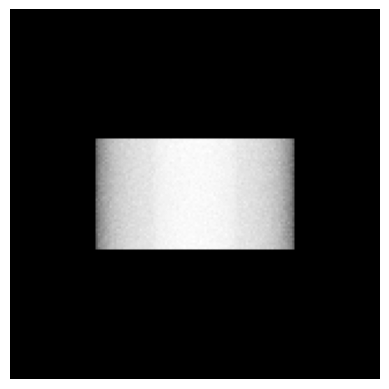

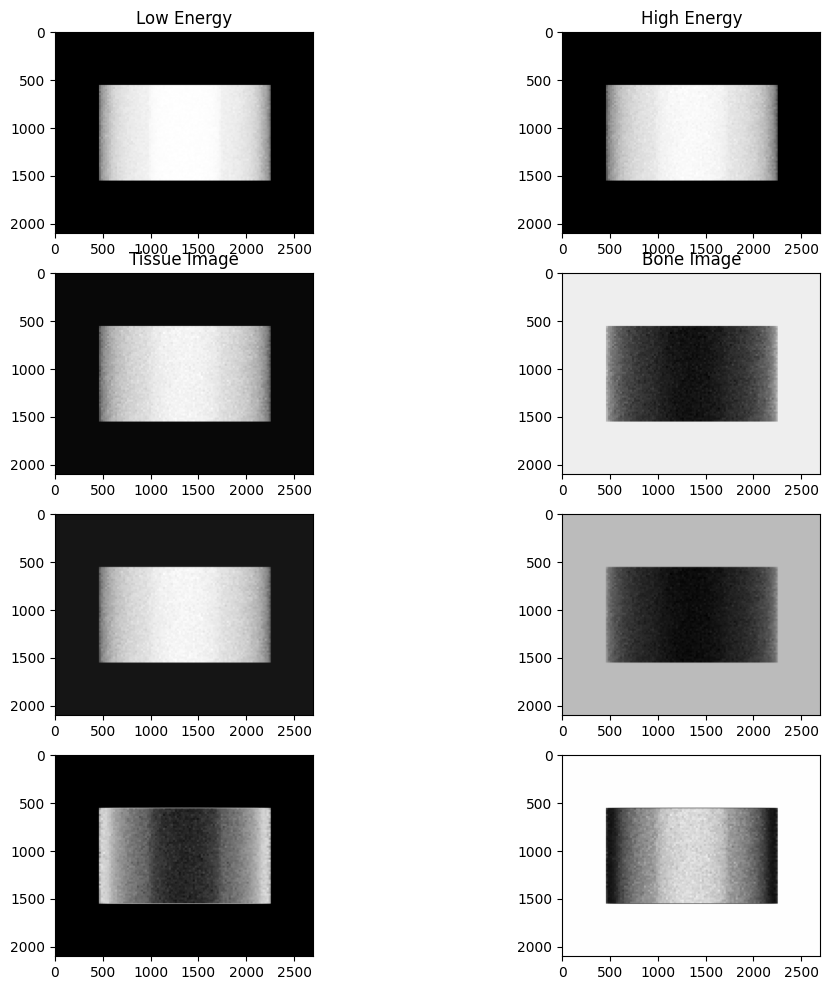

In [6]:
import Isolate_Bone as commet
import cv2
import matplotlib.pyplot as plt

directory = 'RESULTS/'
rootNames = ["arm_40kev_20M", "arm_80kev_20M"]
tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"

size = 100
bins = 80

aux = 0
for i in rootNames: 
    aux += 40
    dataframe = commet.root_to_dask(directory, i, tree_name, x_branch, y_branch, 2)
    htmp_array, xlim, ylim = commet.heatmap_array_dask(dataframe, x_branch, y_branch, size, bins, "20m_"  + str(aux) + "kev")
    
commet.CropImages("20m_80kev.jpg", "20m_40kev.jpg", 400, 700, 3100, 2800, ["cropHe.jpg", "cropLe.jpg"]) #HighImage, LowImage, left, upper, right, lower

low_energy_img = cv2.imread('cropLe.jpg', cv2.IMREAD_GRAYSCALE)
high_energy_img = cv2.imread('cropHe.jpg', cv2.IMREAD_GRAYSCALE)

ratioT =  0.5965832666477631
ratioTb = 0.40058326302016795

tissue_img, bone_img = commet.sls(low_energy_img, high_energy_img, ratioT, ratioTb) # Factor de ponderación w
tissue_img_ssh, bone_img_ssh = commet.ssh(low_energy_img, high_energy_img, ratioT, ratioTb, 2.0) # Parámetro sigma para el filtro gaussiano
tissue_img_acnr, bone_img_acnr= commet.acnr(low_energy_img, high_energy_img, ratioT, ratioTb, 2.0) # Aplicar ACNR

fig, ax = plt.subplots(4, 2, figsize=(12, 12))

# Imagen 1 Original
img1 = ax[0, 0].imshow(low_energy_img, cmap='gray')
ax[0, 0].set_title("Low Energy")

# Imagen 2 Original
img2 = ax[0, 1].imshow(high_energy_img, cmap='gray')
ax[0, 1].set_title("High Energy")

# Tissue Image
img3 = ax[1, 0].imshow(tissue_img, cmap='gray')
ax[1, 0].set_title("Tissue Image")

img4 = ax[1, 1].imshow(bone_img, cmap='gray')
ax[1, 1].set_title("Bone Image")

img5 = ax[2, 0].imshow(tissue_img_ssh, cmap='gray')
ax[1, 1].set_title("Bone Image")
img6 = ax[2, 1].imshow(bone_img_ssh, cmap='gray')
ax[1, 1].set_title("Bone Image")

img7 = ax[3, 0].imshow(tissue_img_acnr, cmap='gray')
img8 = ax[3, 1].imshow(bone_img_acnr, cmap='gray')

plt.tight_layout()
plt.show()